In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
%tensorflow_version 2.x

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from pathlib import Path

import itertools
from functools import partial

DATA_DIR = Path("/content/drive/My Drive/SH/report/data")

NUM_SUBGOALS = 2

tf.keras.backend.clear_session()
tf.__version__

'2.2.0-rc3'

In [0]:
import itertools
import tensorflow as tf
from abc import ABC, abstractmethod
import typing


def scale_to_length(x: tf.Tensor, length: float) -> tf.Tensor:
    magnitude = tf.norm(x, axis=-1, keepdims=True)
    return (length / magnitude) * x


class SamplingTechnique(ABC):

    @abstractmethod
    def initialize(self, num_weights: int):
        pass

    @abstractmethod
    def __call__(self, weights: tf.Tensor) -> typing.Union[tf.Tensor, typing.Iterator[tf.Tensor]]:
        pass


class ExhaustiveSamplingTechnique(SamplingTechnique):
    def __init__(self, sample_radius: float, uniform_radius: bool = True):
        self.sample_radius = sample_radius
        self.uniform_radius = uniform_radius

    def initialize(self, num_weights: int):
        weight_changes = itertools.product([-1, 0, 1], repeat=num_weights)
        # Remove the entry with all zeros
        weight_changes = filter(lambda x: not all(
            map(int(0).__eq__, x)), weight_changes)
        weight_changes = tf.constant(list(weight_changes), dtype=tf.float32)
        if self.uniform_radius:
            weight_changes = scale_to_length(
                weight_changes, self.sample_radius)
        else:
            weight_changes *= self.sample_radius
        self.weight_changes = weight_changes

    def __call__(self, weights: tf.Tensor) -> tf.Tensor:
        return weights + self.weight_changes


class RandomSamplingTechnique(SamplingTechnique):
    def __init__(self, sample_radius: float, num_samples: int, uniform_radius: bool = True):
        self.sample_radius = sample_radius
        self.num_samples = num_samples
        self.uniform_radius = uniform_radius

    def initialize(self, num_weights: int):
        self.num_weights = num_weights

    def __call__(self, weights: tf.Tensor) -> tf.Tensor:
        # Get random samples in the interval (0, 1]
        weight_changes = 1 - \
            tf.random.uniform(
                shape=(self.num_samples, self.num_weights), minval=0, maxval=1, dtype=tf.float32)
        # Make some of these samples negative, so we get the range [-1,1], but excluding 0
        sign = tf.sign(weight_changes - 0.5)
        weight_changes *= tf.where(sign != 0., sign, 1.)
        if self.uniform_radius:
            weight_changes = scale_to_length(
                weight_changes, self.sample_radius)
        else:
            weight_changes *= self.sample_radius
        return weights + weight_changes

In [35]:
# Radial basis activation function: e^(-x^2)
@tf.function
def rbf(x):
    return tf.exp(-tf.pow(x, 2))

# Define model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1,
                          use_bias=False,
                          input_shape=(2,),
                          activation=rbf)
])

initial_weights = np.array([1, 1])[:, np.newaxis].astype(np.float32)
model.weights[0].assign(tf.constant(initial_weights))
model.get_weights()

[array([[1.],
        [1.]], dtype=float32)]

In [0]:
#model.compile(loss="mse", optimizer="sgd", metrics=["binary_accuracy"])
model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])

In [37]:
y = np.array([
    1,
    rbf(2.),
    rbf(2.)
])
x = np.array([
    (2, 2),
    (2, 0),
    (0, 2)
])
x, y

(array([[2, 2],
        [2, 0],
        [0, 2]]), array([1.        , 0.01831564, 0.01831564]))

In [38]:
def compute_subgoals(initial, goal, N, model, x):
    WEIGHTS_SHAPE = list(map(tf.shape, model.get_weights()))

    def get_weights():
        return tf.concat([tf.reshape(x, [-1]) for x in model.get_weights()], axis=0)

    def set_weights(weights):
        if WEIGHTS_SHAPE is None:
            get_weights()

        weights = tf.split(weights, list(map(tf.reduce_prod, WEIGHTS_SHAPE)))
        weights = [tf.reshape(x, shape) for (x, shape) in zip(weights, WEIGHTS_SHAPE)]
        model.set_weights(weights)
    
    def predict_for_weights(weights, x):
        set_weights(weights)
        return model.predict(x)

    subgoal_weights = tf.expand_dims(tf.linspace(0., 1, N), axis=-1) * (goal - initial) + initial

    subgoals = tf.stack([predict_for_weights(weights, x) for weights in subgoal_weights])
    subgoals = tf.squeeze(subgoals)
    
    return subgoal_weights, subgoals


initial = tf.constant([1., 1])
goal = tf.constant([1., -1])
N = NUM_SUBGOALS + 1 # number of subgoals

weights, subgoals = compute_subgoals(initial, goal, N, model, x)

subgoals

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1.12535176e-07, 1.83156393e-02, 1.83156393e-02],
       [1.83156393e-02, 1.83156393e-02, 1.00000000e+00],
       [1.00000000e+00, 1.83156393e-02, 1.83156393e-02]], dtype=float32)>

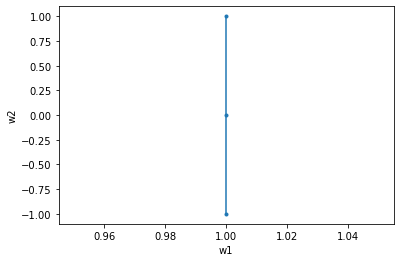

In [39]:
fig, ax = plt.subplots()
ax.set_xlabel("w1")
ax.set_ylabel("w2")
ax.plot(weights[..., 0], weights[..., 1], '.-')

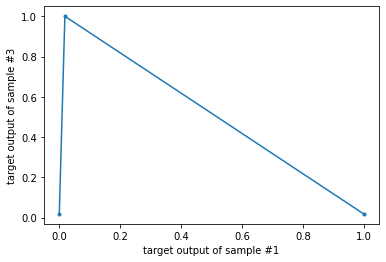

In [40]:
# Let's plot the output space
# Note that two of the samples stay constant throughout. This actually comes in quite handy because we only need a 2D plot to visualize output space instead of a 4D plot.
fig, ax = plt.subplots()
ax.set_xlabel("target output of sample #1")
ax.set_ylabel("target output of sample #3")
ax.plot(subgoals[..., 0], subgoals[..., 2], '.-')

In [0]:
def angle_between(a, b):
    a = a / tf.norm(a, axis=-1, keepdims=True)
    b = b / tf.norm(b, axis=-1, keepdims=True)

    a = tf.expand_dims(a, axis=-2)
    b = tf.expand_dims(b, axis=-1)
    dot = a @ b
    dot = tf.squeeze(dot, axis=(-1, -2))
    return tf.acos(tf.clip_by_value(dot, -1., 1.))

In [42]:
initial_weights = [1, 1]
model.weights[0].assign(tf.constant(np.array(initial_weights).reshape((2, 1)).astype(np.float32)))

training_weights = []
predictions = []
num_epochs = []

def train(model, subgoal, x, learning_rate = 0.01):
    WEIGHTS_SHAPE = list(map(tf.shape, model.get_weights()))

    sampler = ExhaustiveSamplingTechnique(learning_rate, uniform_radius=True)
    sampler.initialize(tf.reduce_sum(tf.reduce_prod(WEIGHTS_SHAPE, axis=-1)))

    def get_weights():
        return tf.concat([tf.reshape(x, [-1]) for x in model.get_weights()], axis=0)

    def set_weights(weights):
        weights = tf.split(weights, list(map(tf.reduce_prod, WEIGHTS_SHAPE)))
        weights = [tf.reshape(x, shape) for (x, shape) in zip(weights, WEIGHTS_SHAPE)]
        model.set_weights(weights)
    
    def predict_for_weights(weights, x):
        set_weights(weights)
        return tf.squeeze(model.predict(x))
    
    predict_fn = partial(predict_for_weights, x=x)
    
    initial_prediction = predict_fn(get_weights())
    training_weights.append(get_weights())
    predictions.append(initial_prediction)

    def get_cost(weight_tests):
        prediction_tests = tf.map_fn(predict_fn, weight_tests)
        if len(training_weights) < 2:
            return tf.norm(prediction_tests - subgoal, axis=-1)
        previous_weights, current_weights = training_weights[-2:]
        current_predictions = predictions[-1]
        
        # Compute strain in weight space
        weight_space_angles = angle_between(tf.broadcast_to(current_weights - previous_weights, current_weights.shape),
                                            weight_tests - current_weights)
        # Compute angle to the goal line
        output_space_angles = angle_between(tf.broadcast_to(subgoal - initial_prediction, current_predictions.shape),
                                            prediction_tests - current_predictions)
        
        return tf.abs(weight_space_angles) + tf.abs(output_space_angles)

    i = 0
    while True:
        curr_weights = training_weights[-1]
        weight_tests = sampler(curr_weights)
        costs = get_cost(weight_tests)
        best_index = tf.argmin(costs)
        proposed_weights = weight_tests[best_index]

        prediction = predict_fn(proposed_weights)

        i+=1

        training_weights.append(proposed_weights)
        predictions.append(prediction)

        if tf.norm(prediction - subgoal) <= .01 * tf.norm(initial_prediction - subgoal):
            print(subgoal, prediction)
            num_epochs.append(i)
            break
    return i

for i, subgoal in enumerate(subgoals[1:], 1):
    print(i, train(model, subgoal, x, learning_rate=.1))

tf.Tensor([0.01831564 0.01831564 1.        ], shape=(3,), dtype=float32) tf.Tensor([0.01831565 0.01831564 1.        ], shape=(3,), dtype=float32)
1 10
tf.Tensor([1.         0.01831564 0.01831564], shape=(3,), dtype=float32) tf.Tensor([1.         0.01831564 0.01831562], shape=(3,), dtype=float32)
2 10


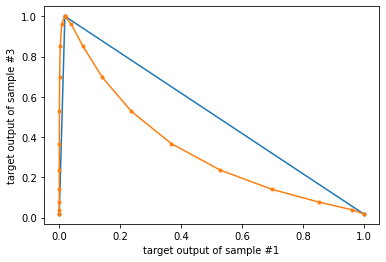

In [43]:
# Let's plot the output space
# Note that two of the samples stay constant throughout. This actually comes in quite handy because we only need a 2D plot to visualize output space instead of a 4D plot.
fig, ax = plt.subplots()
ax.set_xlabel("target output of sample #1")
ax.set_ylabel("target output of sample #3")
ax.plot(subgoals[..., 0], subgoals[..., 2], '.-')

# Plot our predictions
#predictions = np.array(logger.predictions).squeeze()
predictions=np.array(predictions)
ax.plot(predictions[..., 0], predictions[..., 2], '.-')

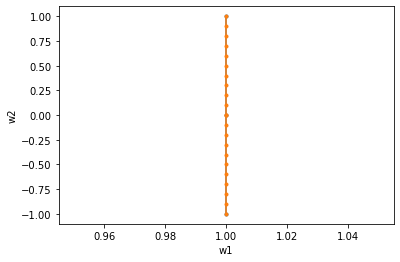

In [44]:
fig, ax = plt.subplots()
ax.set_xlabel("w1")
ax.set_ylabel("w2")
ax.plot(weights[..., 0], weights[..., 1], '.-')

#training_weights = np.array(logger.weights).squeeze()
training_weights = np.array(training_weights).squeeze()
ax.plot(training_weights[..., 0], training_weights[..., 1], '.-')

In [45]:
model.get_weights()

[array([[ 1.       ],
        [-1.0000001]], dtype=float32)]

In [0]:
# Save data

with (DATA_DIR / f"stripe_problem_greedy_probing_modified_cost_{NUM_SUBGOALS}_subgoals__subgoal_weights.dat").open("w") as f:
    for w in weights.numpy():
        f.write("\t".join(map(str, w)) + "\n")

with (DATA_DIR / f"stripe_problem_greedy_probing_modified_cost_{NUM_SUBGOALS}_subgoals__training_weights.dat").open("w") as f:
    size = training_weights.shape[0]
    for w in training_weights:
        f.write("\t".join(map(str, w)) + "\n")

with (DATA_DIR / f"stripe_problem_greedy_probing_modified_cost_{NUM_SUBGOALS}_subgoals__subgoal_outputs.dat").open("w") as f:
    for s in subgoals.numpy():
        s = s[0], s[2]
        f.write("\t".join(map(str, s)) + "\n")

with (DATA_DIR / f"stripe_problem_greedy_probing_modified_cost_{NUM_SUBGOALS}_subgoals__subgoal_outputs_3d.dat").open("w") as f:
    for s in subgoals.numpy():
        f.write("\t".join(map(str, s)) + "\n")

with (DATA_DIR / f"stripe_problem_greedy_probing_modified_cost_{NUM_SUBGOALS}_subgoals__training_outputs.dat").open("w") as f:
    size = predictions.shape[0]
    for s in predictions:
        s = s[0], s[2]
        f.write("\t".join(map(str, s)) + "\n")

with (DATA_DIR / f"stripe_problem_greedy_probing_modified_cost_{NUM_SUBGOALS}_subgoals__training_outputs_3d.dat").open("w") as f:
    size = predictions.shape[0]
    for s in predictions:
        f.write("\t".join(map(str, s)) + "\n")

with (DATA_DIR / f"stripe_problem_greedy_probing_modified_cost_{NUM_SUBGOALS}_subgoals__training_outputs_3d.dat").open("w") as f:
    size = predictions.shape[0]
    for s in predictions:
        f.write("\t".join(map(str, s)) + "\n")

with (DATA_DIR / f"stripe_problem_greedy_probing_modified_cost_{NUM_SUBGOALS}_subgoals__num_epochs_per_subgoal.dat").open("w") as f:
    for i, n in enumerate(num_epochs, 1):
        f.write("\t".join(map(str, (i, n))) + "\n")